**Install necessary packages**

In [2]:
!pip install pyAgrum
!pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00


**Data generation code**

In [25]:
# @title Data generation code
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
# gnb.configuration()
from pylab import *
import os
import pandas as pd
import numpy as np
import statistics
import csv

# db import
from sqlalchemy import create_engine, types
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import register_adapter, AsIs
psycopg2.extensions.register_adapter(np.int64, psycopg2._psycopg.AsIs)

import copy
import datetime
import time
import os
import cairosvg
import random
from tabulate import tabulate
# ____________________________________________________________________________________________________________________________________________________

def connect_to_db(host, user, password, port, database):
    """
    Connects to a PostgreSQL server using the provided credentials.

    Parameters:
        host (str): The IP address or hostname of the PostgreSQL server.
        user (str): The username to connect to the PostgreSQL server.
        password (str): The password associated with the user to connect to the PostgreSQL server.
        port (int): The port number on which the PostgreSQL server listens for connections.
        database (str): The name of the database to connect to or create if it doesn't already exist.

    Returns:
        tuple: A tuple containing the connection object and the cursor object.
               The connection object can be used to execute SQL commands, and the cursor object
               is used to traverse the records from the result set.
    """
    # Connexion au serveur PostgreSQL
    conn = psycopg2.connect(
        host=host,
        user=user,
        password=password,
        port=port)

    cursor = conn.cursor()
    conn.autocommit = True

    # Vérifier si la base de données existe déjà
    cursor.execute("SELECT datname FROM pg_catalog.pg_database WHERE datname = %s", (database,))
    if cursor.fetchone() == None:
        # Créer la base de données si elle n'existe pas
        cursor.execute("CREATE DATABASE "+database)
        print("Database created successfully........")
        cursor.close()
        conn.close()

    # Connexion à la base de données spécifiée
    print("connecting to database...........")
    conn = psycopg2.connect(
        database=database,
        host=host,
        user=user,
        password=password,
        port=port)

    cursor = conn.cursor()
    print("Connection successful!")
    return conn, cursor
# ____________________________________________________________________________________________________________________________________________________
def create_table_from_dataframe(df1, table_name, user, password, host, port, database, cur):
    """
    Creates a PostgreSQL table from a pandas DataFrame.

    Parameters:
        df1 (DataFrame): The pandas DataFrame containing the data to be inserted into the table.
        table_name (str): The name of the table to be created in the database.
        user (str): The username to connect to the PostgreSQL server.
        password (str): The password associated with the user to connect to the PostgreSQL server.
        host (str): The IP address or hostname of the PostgreSQL server.
        port (int): The port number on which the PostgreSQL server listens for connections.
        database (str): The name of the database where the table will be created.

    Returns:
        None
    """

    # Construct the database URI
    database_uri = 'postgresql://' + user + ':' + password + '@' + host + ':' + str(port) + '/' + database

    # Make a copy of the DataFrame and convert column names to lowercase
    df = df1.copy()
    df.columns = map(str.lower, df.columns)

    # Create a SQLAlchemy engine
    engine = create_engine(database_uri)

    # Get column names and types from the DataFrame
    columns = df.dtypes.reset_index()
    columns.columns = ['Column', 'Type']

    # Define mapping between pandas types and SQLAlchemy types
    sqlalchemy_types = {
        'int64': types.BigInteger,
        'int32': types.BigInteger,
        'int8': types.BigInteger,
        'int16': types.BigInteger,
        'integer': types.BigInteger,
        'float64': types.Float,
        'object': types.String,
        'datetime64[ns]': types.DateTime
        # Add more types as needed
    }

    # Map DataFrame types to SQLAlchemy types
    columns['Type'] = columns['Type'].map(str).map(sqlalchemy_types)

    # Create a dictionary for the columns and their data types
    dtype_dict = dict(zip(columns['Column'], columns['Type']))
    # print(dtype_dict)

    # Replace NaN values with None (SQL NULL)
    df = df.where(pd.notna(df), None)

    # Clean and format table name
    table_name = table_name.lower().replace(' ', '')


        ###############################to delete
    # cur.execute(f"DROP TABLE IF EXISTS {table_name};")
    cur.execute(f"SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = '{table_name}');")
    table_exists = cur.fetchone()[0]

    if table_exists:
        # Delete all rows from the table
        cur.execute(f"DELETE FROM {table_name};")

    #     print(f"All rows from table '{table_name}' deleted successfully.")
    # else:
    #     print(f"Table '{table_name}' does not exist.")

        ###############################to delete

    # Create the table
    df.to_sql(table_name, engine, index=False, if_exists='append', dtype=dtype_dict)

    # Close the database connection
    # engine.dispose()
# ____________________________________________________________________________________________________________________________________________________

def show_graphical_info(bn):
    """
    This function displays the graphical information of a Bayesian Network (BN).

    Parameters:
    - bn: The Bayesian Network object to visualize.

    It shows the graphical representation of the BN,
    and displays the inferred marginal probabilities of all nodes in the network.
    """
    print("*" * 50)
    # Display the graphical representation of the BN
    gnb.showBN(bn, size='9')
    # Show the inferred marginal probabilities of all nodes in the network
    gnb.showInference(bn, size="10")
# ____________________________________________________________________________________________________________________________________________________
def generate_data(bn, db_size):
    """
    This function generates synthetic data from a Bayesian Network (BN).

    Parameters:
    - bn: The Bayesian Network object from which to generate data.
    - db_size: The size of the synthetic dataset to generate.

    Returns:
    - df: A Pandas DataFrame containing the generated data.
    """
    # Create a BNDatabaseGenerator object
    g = gum.BNDatabaseGenerator(bn)
    df = pd.DataFrame()
    # Generate synthetic data of the specified size
    g.drawSamples(db_size)
    # Convert the generated data to a Pandas DataFrame
    df = g.to_pandas()
    return df
# ____________________________________________________________________________________________________________________________________________________
def auto_convert_types(df):
    """
    Automatically converts columns in a DataFrame to appropriate data types.

    Parameters:
    - df (DataFrame): The DataFrame containing columns to be converted.

    Returns:
    - df (DataFrame): The DataFrame with converted data types.
    """
    for column in df.columns:
        try:
            # Attempt to convert to numeric, specifying downcast='integer'
            df[column] = pd.to_numeric(df[column], downcast='integer')
            # Check if the resulting dtype is 'int64'
            # if df[column].dtype == 'int64':
            #     # Mark the column as containing integers
            #     # print(f"Column '{column}' contains integers.")
            # else:
            #     # Mark the column as containing continuous values
            #     # print(f"Column '{column}' contains continuous values.")

        except ValueError:
            try:
                df[column] = pd.to_datetime(df[column])
                # Mark the column as containing datetime values
                # print(f"Column '{column}' contains datetime values.")
            except ValueError:
                # Handle other types as needed
                pass
    # print(">>>>>>>>>>>>>>>>>  ",df.dtypes)

    return df

# ____________________________________________________________________________________________________________________________________________________
def database_without_indicator(df, var_indicator):
    """
    Returns a DataFrame without columns indicated by the variable indicator.

    Parameters:
    - df (DataFrame): The original DataFrame.
    - var_indicator (dict): A dictionary where keys are column names and values are indicators.
.
    Returns:
    - df_without_indicator (DataFrame): The DataFrame without the columns indicated by the variable indicator.
    """
    indicator_variables = list(var_indicator.values())
    return df.copy().drop(columns=indicator_variables, errors='ignore')
# ____________________________________________________________________________________________________________________________________________________

def introducing_NAs(df, var_indicator):
    """
    Introduces missing values (NaNs) into DataFrame based on a variable indicator.
    Rename the missing features by adding _star to each feature name

    Parameters:
    - df (DataFrame): The original DataFrame.
    - var_indicator (dict): A dictionary where keys are column names and values are indicators.

    Returns:
    - df1 (DataFrame): The DataFrame with introduced missing values.
    """
    df1 = df.copy()
    for var_key in var_indicator:
        var_star = var_key + '_star'
        df1.rename(columns={var_key: var_star}, inplace=True)
        df1.loc[df1[var_indicator[var_key]] == 1, var_star] = np.NAN

    return df1
# ____________________________________________________________________________________________________________________________________________________
def database_without_Vms_variables(df, var_indicator):
    """
    Returns a DataFrame without columns indicated by the variable indicator.

    Parameters:
    - df (DataFrame): The original DataFrame.
    - var_indicator (dict): A dictionary where keys are column names and values are indicators.

    Returns:
    - df_without_Vms (DataFrame): The DataFrame without the partially observed variables (Vms).
    """
    part_obsrv_variables = list(var_indicator.keys())
    return df.copy().drop(columns=part_obsrv_variables, errors='ignore')
# ____________________________________________________________________________________________________________________________________________________
def save_output_files(title, tables_df, bn, size, timestamp_str, missing_rate,
    var_indicator, storing_option,user,password,host,port,database):
  # results_list = all_answers_list.copy()

  # Google Colab's base directory
  base_directory = "/content/data/raw"  # Colab default path is '/content'

  # Print title for debugging
  print(title)

  # Create the base directory if it doesn't exist
  os.makedirs(base_directory, exist_ok=True)

  # Create subdirectories for title and size
  subdirectory = os.path.join(base_directory, title, str(size))
  os.makedirs(subdirectory, exist_ok=True)

  # Create a timestamped subdirectory
  directory_example = os.path.join(subdirectory, timestamp_str)
  os.makedirs(directory_example, exist_ok=True)

  svg_string = gnb.getBN(bn,size='24')


  # saving basic information about the incomplete db
  with open(directory_example+"/summary_incomplete_db.txt", 'w') as f:
    # Write the first few rows of the DataFrame
    f.write("Incomplete database summary:\n")

    # Write basic statistics
    f.write("Basic statistics:\n")
    stats_str = tables_df["incomplete_database"].describe(include='all').to_string()
    f.write(stats_str)
    f.write("\n\n")

    # Write missing values count
    f.write("Missing rate:\n")
    missing_values_str = (tables_df["incomplete_database"].isna().sum()/tables_df["incomplete_database"].shape[0]*100).to_string()
    f.write(missing_values_str)
    f.write("\n\n")

    # Write data types
    f.write("Data types:\n")
    dtypes_str = tables_df["incomplete_database"].dtypes.to_string()
    f.write(dtypes_str)
    f.write("\n")

  # storing the generated dbs
  for table_name, table_df in tables_df.items():
    csv_file_path = f"{directory_example}/{table_name}.csv"

    # storing option 0: save as CSV files only
    if storing_option == 0:
        table_df.to_csv(csv_file_path, index=False)

    # storing option 1: save in the Postgres DB only
    elif storing_option == 1:
        # Connect to the database
        conn, cursor = connect_to_db(host, user, password, port, database)
        create_table_from_dataframe(table_df, table_name, user, password, host, port, database, cursor)
        print("closing connection ...................")
        # Close the database connection
        cursor.close()
        conn.close()

    # storing option 2: save in both CSV and Postgres DB
    elif storing_option == 2:
        table_df.to_csv(csv_file_path, index=False)
        # Connect to the database
        conn, cursor = connect_to_db(host, user, password, port, database)
        create_table_from_dataframe(table_df, table_name, user, password, host, port, database, cursor)
        print("closing connection ...................")
        # Close the database connection
        cursor.close()
        conn.close()


  # storing the graphical format of the Bayesian network
  output_png_path = directory_example+'/'+"bn.png"
  cairosvg.svg2png(bytestring=svg_string, write_to=output_png_path)

# error saving the bif file
  try:
    gum.saveBN(bn,directory_example+'/'+"bn.bif", True)
  except gum.FatalError as e:
    print(f"Error: {e}. Skipping the variable.")
    pass  # Skip the variable and continue with the next one
# ____________________________________________________________________________________________________________________________________________
def remove_star_suffix(df1):

  df = df1.copy()
  # identify those columns with _star
  star_columns = [col for col in df.columns if col.endswith('_star')]

  # Create a dictionary for renaming columns
  rename_dict = {col: col[:-5] for col in star_columns}

  # Rename columns
  df.rename(columns=rename_dict, inplace=True)

  return df
# ____________________________________________________________________________________________________________________________________________________
def keys_to_str(dictionary):
    if isinstance(dictionary, dict):
        return {tuple(map(str, k)): keys_to_str(v) for k, v in dictionary.items()}
    else:
        return dictionary
# ____________________________________________________________________________________________________________________________________________________
def conditional_probability(bn, full_obsrv_vars, proxy_vars, is_quantitative_mg, row):
    """
    Computes the conditional probability distribution based on a Bayesian Network (BN) for a given set of observed variables.

    Parameters:
    - bn: The Bayesian Network object used for inference.
    - full_obsrv_vars: A list of fully observed variables, which are used to compute the conditional probability.
    - proxy_vars: A list of proxy variables, which are used to condition the distribution.
    - is_quantitative_mg: A boolean indicating if the model is quantitative.
    - row: A dictionary where keys are variable names and values are their corresponding observations.

    Returns:
    - cond_dist: The conditional probability distribution given the observed variables.
    """

    # Initialize LazyPropagation for inference on the Bayesian Network
    ie = gum.LazyPropagation(bn)
    ie.makeInference()

    # Remove 'DuplicatesCount' from the set of fully observed variables
    full_obsrv_vars = set(full_obsrv_vars).difference(["DuplicatesCount"])

    # Create lists of full and partial observed variables without the '_star' suffix
    full_vars = [v.replace('_star', '') for v in full_obsrv_vars]
    partial_obsrv_vars = [v.replace("_star", "") for v in proxy_vars]

    # Create a list of indicators for partial observed variables (prefix with 'I')
    indicators_list = ['I' + v for v in partial_obsrv_vars]

    # Compute the conditional distribution based on whether the model is quantitative
    if is_quantitative_mg:
        cond_dist = ie.evidenceJointImpact(partial_obsrv_vars, full_vars + indicators_list)
        # Extract the distribution for cases where indicators are equal to 1
        for var in indicators_list:
            cond_dist = cond_dist.extract({var: 1})
    else:
        cond_dist = ie.evidenceJointImpact(partial_obsrv_vars, full_vars)

    # Extract the distribution for each fully observed variable based on its observed value
    for full_ob_var in full_obsrv_vars:
        var = full_ob_var.replace("_star", "")
        var_id = bn.variable(bn.idFromName(var))
        value_id = var_id.index(str(int(row[full_ob_var])))
        cond_dist = cond_dist.extract({var: value_id})

    return cond_dist
# ________________________________________________________________________________________________________________________
def compute_probabilistic_db(df, bn, var_indicator):
    """
    Compute a probabilistic database by defining super blocks based on tuples with missing values and their conditional probabilities.

    Parameters:
        df (DataFrame): The initial DataFrame containing tuples with potential missing values.
        bn (BayesianNetwork): A Bayesian Network model used for probability calculations.
        var_indicator (dict): A dictionary where keys are variable names and values indicate indicator variables.

    Returns:
        DataFrame: A DataFrame representing the probabilistic database with super blocks.
    """
    prob_db = []

    # Retrieve the first partially observed variable
    partial_obsrv_var = list(var_indicator.keys())[0]

    # Get the parent nodes of the partially observed variable
    parents_set = bn.parents(bn.idFromName(partial_obsrv_var))

    # Retrieve names of the parent nodes
    parents_names = [bn.variable(v).name() for v in parents_set]

    # Iterate over rows with potentially missing values
    for index, row in df.iterrows():
        # Identify which variables have missing values
        proxy_vars_with_missing_values = set(row.index[row.isnull()])
        # Identify which variables are fully observed
        fully_observed_vars = set(row.index[~row.isnull()])
        # List of variables with missing values
        proxy_vars = list(proxy_vars_with_missing_values)

        # Define the block and compute the probability if there are missing values
        if len(proxy_vars) > 0:
            # Calculate the conditional probability for the current tuple
            cp = conditional_probability(bn, fully_observed_vars, proxy_vars_with_missing_values,
                                          True, row)

            # Collect possible tuples
            possible_tuples = []
            for i in cp.loopIn():
                new_row = row.copy()
                for var in proxy_vars:
                    value = bn.variable(bn.idFromName(var.replace("_star", ""))).label(i[var.replace("_star", "")])
                    # Update row with values for proxy variables
                    if pd.api.types.is_float_dtype(df.dtypes[var]):
                        new_row[var] = float(value)
                    else:
                        new_row[var] = value
                new_row["probability"] = cp.get(i)
                new_row["block_id"] = index

                possible_tuples.append(new_row)
            # Append all possible tuples to the prob_db list
            prob_db.extend(possible_tuples)

        else:
            # If no missing values, assign a probability of 1
            row["probability"] = 1
            row["block_id"] = index
            prob_db.append(row)

    # Convert list of dictionaries to DataFrame
    prob_db_df = pd.DataFrame(prob_db)

    # Rearrange the 'block_id' column to be the first column
    block_id_col = prob_db_df.pop("block_id")
    prob_db_df.insert(0, 'block_id', block_id_col)

    # Remove suffixes and convert data types
    return remove_star_suffix(auto_convert_types(prob_db_df))
# ________________________________________________________________________________
def convert_row_types(row):
    converted_row = row.copy()  # Create a copy of the original row
    for idx, value in row.iteritems():
        try:
            converted_value = float(value)  # Convert to float
            if not np.isnan(converted_value):  # Check if the value is not NaN
                converted_value = int(converted_value)  # Convert to integer
            converted_row[idx] = converted_value
        except ValueError:
            pass  # If unable to convert, keep it as it is
    return converted_row

# __________________________________________________________________________________________________________________________________________________
def databases_generator(bn, var_indicator, db_size):
    """
    Generate and process different versions of a database using a Bayesian Network model.

    Parameters:
        bn (BayesianNetwork): The Bayesian Network model used for data generation and probability computations.
        var_indicator (dict): Dictionary indicating indicator variables for handling missing values.
        db_size (int): The desired size of the generated database.

    Returns:
        dict: A dictionary containing the complete database, incomplete database, expanded format, and probabilistic database.
    """

    print("Start generating the initial data by pyAgrum")
    # Generate an initial dataset using the Bayesian Network model
    df = generate_data(bn, db_size)
    print("pyAgrum has finished generating the initial data")

    # Convert data types in the DataFrame to appropriate types
    df = auto_convert_types(df)
    tabulate(df, headers='keys', tablefmt='pretty')

    # Create a complete database by removing indicator variables
    complete_database = database_without_indicator(df.copy(), var_indicator)
    print("The complete database\n", tabulate(complete_database, headers='keys', tablefmt='pretty'))
    # print()

    print("Generating the incomplete database D*")

    # Introduce missing values into the DataFrame according to the indicator variables
    df_all_database_information = introducing_NAs(df.copy(), var_indicator)
    print("The expanded format of the database\n", tabulate(df_all_database_information, headers='keys', tablefmt='pretty'))

    # Remove variables related to VMs and create an incomplete database
    incomplete_database = database_without_indicator(
        database_without_Vms_variables(df_all_database_information, var_indicator),
        var_indicator
    )
    print("The incomplete database\n", tabulate(incomplete_database, headers='keys', tablefmt='pretty'))

    print("computing the Probabilistic database")
    # Compute the probabilistic database from the incomplete database
    pdb = compute_probabilistic_db(incomplete_database.copy(), bn, var_indicator)
    print("Probabilistic database\n", tabulate(pdb, headers='keys', tablefmt='pretty'))

    # Return a dictionary containing all versions of the database
    return {
        "complete_database": complete_database,
        "incomplete_database": incomplete_database,
        "expanded_format": df,
        "prob_db": pdb
    }

# ____________________________________________________________________________________________________________________________________________________

def load_BN_from_bif(bn_path):
    return gum.loadBN(bn_path)
# ____________________________________________________________________________________________________________________________________________________

def synthetic_data_experiment(host, user, password, port, database, bn, db_size, var_indicator, missing_rate, storing_option):
    """
    Conduct an experiment by generating synthetic data, adding missing values, and storing the results in a database.

    Parameters:
        host (str): The hostname of the database server.
        user (str): The username for database authentication.
        password (str): The password for database authentication.
        port (int): The port number on which the database server is listening.
        database (str): The name of the database where the data will be stored.
        bn (BayesianNetwork): The Bayesian Network model used to generate the synthetic data.
        db_size (int): The size of the synthetic dataset to be generated.
        var_indicator (dict): Dictionary indicating indicator variables for handling missing values.
        missing_rate (float): The rate of missingness to be applied to the data.
        storing_option (str): Option specifying where to store the generated data.

    Returns:
        None
    """

    # Print message indicating the start of the experiment with details
    print(f"=============>>> running example {database} with missingness rate = {missing_rate}")

    # Prepare the database name with a timestamp for uniqueness
    relation_name = database
    timestamp_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    database = f"{relation_name}_{timestamp_str}".lower().replace('-', '').replace(' ', '')



    # Display graphical information of the Bayesian Network
    show_graphical_info(bn)

    # Generate synthetic data using the Bayesian Network model and specified parameters
    dbs = databases_generator(bn, var_indicator, db_size)

    # Save the generated data and other relevant information to the database
    save_output_files(
        relation_name, dbs, bn, db_size, timestamp_str, missing_rate,
        var_indicator, storing_option, user, password, host, port, database)

    # Print message indicating the completion of the process
    print("done!")



**Proposed quantitative missingness graphs (Bayesian networks)**

In [6]:
# @title Proposed quantitative missingness graphs (Bayesian networks)
import pyAgrum as gum
import random
# -------------------------------------------------------------------------------------
def double_mar(r):
    bn=gum.BayesNet('experiment')
    example_title = 'double_mar'

    o=1-r
    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,]))
    vB=bn.add(gum.IntegerVariable('B','B',[10,100]))
    vC=bn.add(gum.IntegerVariable('C','C',[4,7]))
    vIC=bn.add(gum.LabelizedVariable('IC','IC',2))

    # defining dependencies between the variables
    # bn.addArc(vA,vB)
    bn.addArc(vA,vB)
    bn.addArc(vA,vIC)
    bn.addArc(vB,vC)
    bn.addArc(vB,vIC)

    # defining the absolute and the conditional probs
    bn.cpt(vA).fillWith([0.2,0.8])
    bn.cpt(vB)[:]=[[0.2,0.8],[0.9,0.1]]
    bn.cpt(vC)[:]=[[0.8, 0.2],[0.8, 0.2]]

    bn.cpt(vIC)[0, 0, :] = [0.1, 0.9]
    bn.cpt(vIC)[0, 1, :] = [1, 0]
    # bn.cpt(vIC)[0, 2, :] = [0.1, 0.2, 0.3, 0.1, 0.3]

    bn.cpt(vIC)[1, 0, :] = [1, 0]
    bn.cpt(vIC)[1, 1, :] = [r, o]
    # bn.cpt(vIC)[1, 2, :] = [0.1, 0.2, 0.3, 0.1, 0.3]

    # bn.cpt(vIC)[2, 0, :] = [0.1, 0.2, 0.3, 0.1, 0.3]
    # bn.cpt(vIC)[2, 1, :] = [0.1, 0.2, 0.3, 0.3, 0.1]
    # bn.cpt(vIC)[2, 2, :] = [0.1, 0.2, 0.3, 0.1, 0.3]

    var_indicator = {'C':'IC'}

    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def mar__1(r):
    bn=gum.BayesNet('experiment')
    example_title = 'mar__1'

    o=1-r

    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,3,4,5,6,7,8,9,10]))
    vB=bn.add(gum.IntegerVariable('B','B',[10,100]))
    vC=bn.add(gum.IntegerVariable('C','C',[4,7]))
    vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

    # defining dependencies between the variables
    # bn.addArc(vA,vB)
    bn.addArc(vA,vIB)

    # defining the absolute and the conditional probs
    bn.cpt(vA).fillWith([0.5,0.05,0.05,0.05,0.05,0.05,0.05,0.1,0.05,0.05])
    bn.cpt(vB)[:]=[ 0.8, 0.2]
    bn.cpt(vC)[:]=[ 0.1, 0.9]
    bn.cpt(vIB)[:]=[ [1,0],[o, r],[o, r],[o, r],[1,0],[o, r],[o, r],[o, r],[1,0],[o, r]]

    var_indicator = {'B':'IB'}

    return bn, var_indicator, example_title

# -------------------------------------------------------------------------------------
# def mar__2(r):
#     bn=gum.BayesNet('experiment')
#     example_title = 'mar__2'

#     o=1-r

#     # defininig the variables and their domains
#     vA=bn.add(gum.IntegerVariable('A','A',[1,2,3,4,5,6,7,8,9,10]))
#     vB=bn.add(gum.IntegerVariable('B','B',[10,100, 1000]))
#     vC=bn.add(gum.IntegerVariable('C','C',[4,7, 9]))
#     vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

#     # defining dependencies between the variables
#     bn.addArc(vA,vB)
#     bn.addArc(vC,vB)
#     # bn.addArc(vA,vIB)

#     # defining the absolute and the conditional probs
#     bn.cpt(vA).fillWith([0.5,0.05,0.05,0.05,0.05,0.05,0.05,0.1,0.05,0.05])
#     # bn.cpt(vB)[:]=[ 0.8, 0.2]
#     bn.cpt(vC)[:]= random_triplet_sum_to_one()
#     # [ 0.235489, 0.474295, 0.290216]

#     for i in range(3):
#       for j in range(10):
#         if i + 1 < j :
#           bn.cpt(vB)[i, j, :] = random_triplet_sum_to_one()
#           # [0.33, 0.33, 0.33]
#         else:
#           bn.cpt(vB)[i, j, :] = random_triplet_sum_to_one()

#     # bn.cpt(vIB)[:]=[ [1,0],[o, r],[o, r],[o, r],[1,0],[o, r],[o, r],[o, r],[1,0],[o, r]]
#     bn.cpt(vIB)[:]=[0.2,0.8]

#     var_indicator = {'B':'IB'}

#     return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def mar01(r):
    bn=gum.BayesNet('experiment')
    example_title = 'MAR-01'

    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,3]))
    vB=bn.add(gum.IntegerVariable('B','B',[10, 100, 1000, 10000, 100000]))
    vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

    # defining dependencies between the variables
    bn.addArc(vA,vB)
    bn.addArc(vA,vIB)

    # defining the absolute and the conditional probs
    alpha1 = 0.4
    alpha2 = 0.2
    alpha3 = 0.4
    bn.cpt(vA).fillWith([alpha1, alpha2, alpha3])
    bn.cpt(vB)[:]=[ [0.2, 0.3, 0.5, 0, 0],[0, 0.3, 0.3, 0.4, 0], [0.01, 0.19, 0, 0, 0.8]]

    r1 = r/2
    o1 = 1-r1
    r2 = (r - r1 *(alpha1 + alpha3))/alpha2
    bn.cpt(vIB)[:]=[ [o1, r1], [1 - r2, r2], [o1, r1]]

    var_indicator = {'B':'IB'}


    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def mar_1(r):
    bn=gum.BayesNet('experiment')
    example_title = 'MAR-1'

    o=1-r

    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,3]))
    vB=bn.add(gum.IntegerVariable('B','B',[10,100, 1000, 10000, 100000]))
    vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

    # defining dependencies between the variables
    bn.addArc(vA,vB)
    bn.addArc(vA,vIB)

    # defining the absolute and the conditional probs
    bn.cpt(vA).fillWith([0.4,0.2, 0.4])
    bn.cpt(vB)[:]=[ [0.2, 0.3, 0.5, 0, 0],[0, 0.3, 0.3, 0.4, 0], [0, 0, 0, 0, 1]]
    bn.cpt(vIB)[:]=[ [o, r],[1, 0], [o, r]]

    var_indicator = {'B':'IB'}

    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def mar_2(r):
    bn=gum.BayesNet('experiment')
    example_title = 'MAR-2'

    o=1-r

    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,3]))
    vB=bn.add(gum.IntegerVariable('B','B',[13,55, 100, 999]))
    vC=bn.add(gum.IntegerVariable('C','C',[3,5, 100]))
    vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

    # defining dependencies between the variables
    bn.addArc(vA,vB)
    bn.addArc(vC,vIB)

    # defining the absolute and the conditional probs
    bn.cpt(vA).fillWith([0.5,0.2, 0.3])
    bn.cpt(vC).fillWith([0.3, 0.2, 0.5])
    bn.cpt(vB)[:]=[ [0, 0, 1, 0],[0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25]]
    bn.cpt(vIB)[:]=[ [o, r],[1, 0], [o, r]]

    # this dictionary hold all the variables and their indicators
    var_indicator = {'B':'IB'}

    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def mar_3(r):
    bn=gum.BayesNet('experiment')
    example_title = 'MAR-3'

    o=1-r

    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,3]))
    vB=bn.add(gum.IntegerVariable('B','B',[13,55, 100, 999]))
    vC=bn.add(gum.IntegerVariable('C','C',[3,5, 100]))
    vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

    # defining dependencies between the variables
    bn.addArc(vA,vB)
    bn.addArc(vA,vC)
    bn.addArc(vC,vIB)

    # defining the absolute and the conditional probs
    bn.cpt(vA).fillWith([0.5,0.2, 0.3])
    # bn.cpt(vC).fillWith([0.3, 0.2, 0.5])
    bn.cpt(vB)[:]=[ [0, 0, 1, 0],[0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25]]
    bn.cpt(vC)[:]=[ [0, 0, 1],[0.25, 0.5, 0.25], [0.5, 0.25, 0.25]]
    bn.cpt(vIB)[:]=[ [o, r],[o, r], [o, r]]

    # this dictionary hold all the variables and their indicators
    var_indicator = {'B':'IB'}

    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def mar_5(r):
    bn=gum.BayesNet('experiment')
    example_title = 'MAR-5'

    o=1-r

    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,3]))
    vB=bn.add(gum.IntegerVariable('B','B',[10,100, 1000, 10000, 100000]))
    vC=bn.add(gum.IntegerVariable('C','C',[11,18,33]))
    vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

    # defining dependencies between the variables
    bn.addArc(vA,vB)
    # bn.addArc(vA,vC)
    bn.addArc(vA,vIB)

    # defining the absolute and the conditional probs
    bn.cpt(vA).fillWith([0.4,0.2, 0.4])
    bn.cpt(vB)[:]=[ [0.2, 0.2, 0, 0, 0.6],[0, 0.3, 0.3, 0.4, 0], [0.4, 0.1, 0.2, 0.2, 0.1]]
    bn.cpt(vC)[:]= [0.25, 0.25, 0.5,]
    bn.cpt(vIB)[:]=[ [o, r],[1, 0], [o, r]]

    var_indicator = {'B':'IB'}

    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def mar_6(r):
    bn=gum.BayesNet('experiment')
    example_title = 'MAR-6'

    o=1-r

    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,3]))
    vB=bn.add(gum.IntegerVariable('B','B',[10,100, 1000, 10000, 100000]))
    vC=bn.add(gum.IntegerVariable('C','C',[11,18,33]))
    vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

    # defining dependencies between the variables
    bn.addArc(vA,vB)
    bn.addArc(vA,vIB)

    # defining the absolute and the conditional probs
    bn.cpt(vA).fillWith([0.4,0.2, 0.4])
    bn.cpt(vB)[:]=[ [1, 0, 0, 0, 0],[0, 0.3, 0.3, 0.4, 0], [0, 0, 0, 0, 1]]
    bn.cpt(vC).fillWith([0.4,0.3,0.3])
    bn.cpt(vIB)[:]=[ [o, r],[1, 0], [o, r]]

    var_indicator = {'B':'IB'}

    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def mar_1_bis(r):
    bn=gum.BayesNet('experiment')
    example_title = 'MAR-1_0'
    o=1-r

    # defininig the variables and their domains
    vA=bn.add(gum.IntegerVariable('A','A',[1,2,3,4,5,6]))
    vB=bn.add(gum.IntegerVariable('B','B',[10,100, 1000, 10000, 100000, 1000000]))
    vIB=bn.add(gum.LabelizedVariable('IB','IB',2))

    # defining dependencies between the variables
    bn.addArc(vA,vB)
    bn.addArc(vA,vIB)

    # defining the absolute and the conditional probs
    bn.cpt(vA).fillWith([0.2,0.1, 0.2,0.1,0.1,0.3])
    bn.cpt(vB)[:]=[ [0.3, 0, 0.3, 0.1, 0.1, 0.2],[0, 0.3, 0.3, 0.4, 0,0], [0.2, 0.2, 0.2, 0, 0.2, 0.2], [0.3, 0, 0.3, 0.1, 0.1, 0.2], [0, 0.3, 0.3, 0.4, 0, 0],[0, 0, 0, 0, 0.5, 0.5]]
    bn.cpt(vIB)[:]=[ [0.8, 0.2],[1, 0], [o, r],[o, r], [0.9,0.1],[o, r]]

    var_indicator = {'B':'IB'}

    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------
def bn_example_five_(r):
    example_title = 'MAR_example'
    bn=gum.BayesNet(example_title)

    o=1-r

    vA=bn.add(gum.IntegerVariable('A','A',[2, 13, 18, 20]))
    vB=bn.add(gum.IntegerVariable('B','B',[3, 14, 24, 98]))
    vC=bn.add(gum.IntegerVariable('C','C',[4, 15, 78, 123, 245]))
    vIC=bn.add(gum.LabelizedVariable('IC','IC',2))

    bn.addArc(vA,vC)
    bn.addArc(vB,vC)
    bn.addArc(vB,vIC)
    bn.addArc(vA,vIC)

    bn.cpt(vA).fillWith([0.2,0.2,0.3,0.3])
    bn.cpt(vB).fillWith([0.3,0.2,0.3,0.2])

    bn.cpt(vC)[0, 0, :] = [0.1, 0.2, 0.3, 0.1, 0.3]
    bn.cpt(vC)[0, 1, :] = [0.1, 0.2, 0.3, 0.3, 0.1]
    bn.cpt(vC)[0, 2, :] = [0.1, 0.2, 0.3, 0.1, 0.3]
    bn.cpt(vC)[0, 3, :] = [0.1, 0.2, 0.3, 0.3, 0.1]

    bn.cpt(vC)[1, 0, :] = [0.2, 0.2, 0.2, 0.2, 0.2]
    bn.cpt(vC)[1, 1, :] = [0.2, 0.2, 0.2, 0.2, 0.2]
    bn.cpt(vC)[1, 2, :] = [0.2, 0.2, 0.2, 0.2, 0.2]
    bn.cpt(vC)[1, 3, :] = [0.2, 0.2, 0.2, 0.2, 0.2]

    bn.cpt(vC)[2, 0, :] = [0.2, 0.2, 0.2, 0.2, 0.2]
    bn.cpt(vC)[2, 1, :] = [0.2, 0.2, 0.2, 0.2, 0.2]
    bn.cpt(vC)[2, 2, :] = [0.2, 0.2, 0.2, 0.2, 0.2]
    bn.cpt(vC)[2, 3, :] = [0.2, 0.2, 0.2, 0.2, 0.2]

    bn.cpt(vC)[3, 0, :] = [0.1, 0.2, 0.3, 0.1, 0.3]
    bn.cpt(vC)[3, 1, :] = [0.1, 0.2, 0.3, 0.3, 0.1]
    bn.cpt(vC)[3, 2, :] = [0.1, 0.2, 0.3, 0.1, 0.3]
    bn.cpt(vC)[3, 3, :] = [0.1, 0.2, 0.3, 0.3, 0.1]

# _____________________________________________________
    bn.cpt(vIC)[0, 0, :] = [1,0]
    bn.cpt(vIC)[0, 1, :] = [1,0]
    bn.cpt(vIC)[0, 2, :] = [o,r]
    bn.cpt(vIC)[0, 3, :] = [o,r]

    bn.cpt(vIC)[1, 0, :] = [1,0]
    bn.cpt(vIC)[1, 1, :] = [1,0]
    bn.cpt(vIC)[1, 2, :] = [o,r]
    bn.cpt(vIC)[1, 3, :] = [o,r]

    bn.cpt(vIC)[2, 0, :] = [1,0]
    bn.cpt(vIC)[2, 1, :] = [1,0]
    bn.cpt(vIC)[2, 2, :] = [o,r]
    bn.cpt(vIC)[2, 3, :] = [o,r]

    bn.cpt(vIC)[3, 0, :] = [1,0]
    bn.cpt(vIC)[3, 1, :] = [1,0]
    bn.cpt(vIC)[3, 2, :] = [o,r]
    bn.cpt(vIC)[3, 3, :] = [o,r]

    # bn.cpt(vIC)[:]=[ [1, 0],[1, 0],[o, r],[o, r]]

    # this dictionary hold all the variables and their indicators
    var_indicator = {'C':'IC'}

    return bn, var_indicator, example_title
# -------------------------------------------------------------------------------------


**Data generation**

=============>>> running example database_MAR_example with missingness rate = 0.1
**************************************************


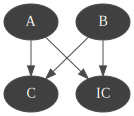

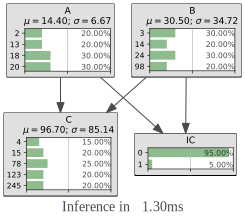

Start generating the initial data by pyAgrum
pyAgrum has finished generating the initial data
The complete database
 +-----+----+----+-----+
|     | A  | B  |  C  |
+-----+----+----+-----+
|  0  | 18 | 14 | 123 |
|  1  | 18 | 14 |  4  |
|  2  | 18 | 24 | 15  |
|  3  | 18 | 3  | 245 |
|  4  | 20 | 3  | 78  |
|  5  | 2  | 14 | 78  |
|  6  | 18 | 14 | 123 |
|  7  | 20 | 98 |  4  |
|  8  | 18 | 3  |  4  |
|  9  | 18 | 14 | 15  |
| 10  | 18 | 3  | 78  |
| 11  | 18 | 24 | 78  |
| 12  | 18 | 24 |  4  |
| 13  | 20 | 14 | 15  |
| 14  | 20 | 98 | 123 |
| 15  | 20 | 3  | 78  |
| 16  | 2  | 98 | 78  |
| 17  | 18 | 3  | 245 |
| 18  | 20 | 24 | 245 |
| 19  | 13 | 3  | 123 |
| 20  | 2  | 3  | 245 |
| 21  | 2  | 24 | 245 |
| 22  | 18 | 24 | 78  |
| 23  | 20 | 24 | 15  |
| 24  | 18 | 3  | 78  |
| 25  | 2  | 3  | 245 |
| 26  | 13 | 98 | 123 |
| 27  | 2  | 24 | 78  |
| 28  | 20 | 3  | 123 |
| 29  | 18 | 98 | 245 |
| 30  | 18 | 24 | 78  |
| 31  | 2  | 24 | 15  |
| 32  | 2  | 3  | 78  |
| 33  | 2  | 24 | 7

In [26]:
# @title Main
import sys
import os
import pyAgrum as gum

# # Add directories to the Python path
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), 'quantitative_bayesian_networks', 'generators')))
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), 'src')))

# from graphs_mcar import mcar_1
# from src.data_generation import synthetic_data_experiment

def main():
    # Configuration Parameters
    host = "localhost"        # Database host address
    user = "postgres"         # Database username
    password = "postgres"     # Database password
    port = 5432               # Database port
    db_size = 300           # The size of the dataset to be generated
    miss_rate = 0.1           # The rate at which values will be missing in the dataset
    storing_option = 0        # 0 = Save as CSV files, 1 = Save in Postgres, 2 = Save in both

    # Define the missingness graph models
    examples = [bn_example_five_(miss_rate)]  # mcar_1 is a model for generating missing values

    # Generate the synthetic data for each example
    for example in examples:
        bn, var_indicator, relation_name = example
        # synthetic_data_experiment(host, user, password, port, database, bn, db_size, var_indicator, missing_rate, storing_option)
        synthetic_data_experiment(
            host=host,
            user=user,
            password=password,
            port=port,
            database="database_"+relation_name,
            bn=bn,
            db_size=db_size,
            var_indicator=var_indicator,
            missing_rate=miss_rate,
            storing_option=storing_option
        )

if __name__ == "__main__":
    main()


**PyAgrum data generation quality**

In the following section, we evaluate the quality of data generated using pyAgrum. We demonstrate that as the size of the generated data increases, the distance between the joint probability distribution induced by the graph and the empirical distribution of the generated data approaches zero.

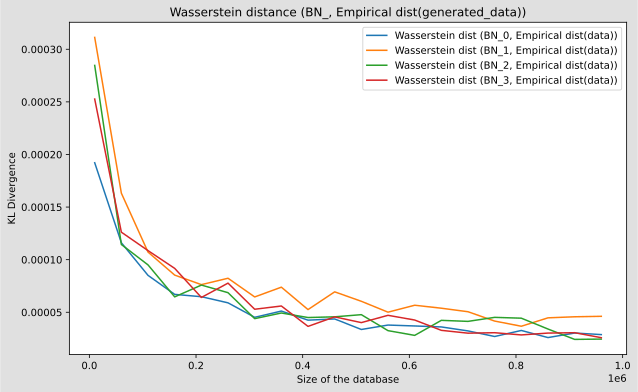

In [ ]:
# @title PyAgrum data generation quality
variable_name = ""
variable_name = 3
import pyAgrum as gum
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import statistics
from sqlalchemy import create_engine
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import register_adapter
from scipy.stats import wasserstein_distance
import math
from sklearn.metrics import mean_squared_error, f1_score

# Register numpy int64 adapter for PostgreSQL
psycopg2.extensions.register_adapter(np.int64, psycopg2._psycopg.AsIs)


# ____________________________________________________________________________________________________________________________________________________
def load_BN_from_bif(bn_path):
    """
    Load a Bayesian network (BN) from a .bif file.

    Parameters:
    - bn_path: Path to the .bif file.

    Returns:
    - The loaded Bayesian network.
    """
    return gum.loadBN(bn_path)


# ____________________________________________________________________________________________________________________________________________________
def compute_marginal_distribution(dataframe, variable_index):
    """
    Compute the marginal probability distribution for a specific variable in a DataFrame.

    Parameters:
    - dataframe: The DataFrame containing the data.
    - variable_index: The index of the variable for which to compute the marginal distribution.

    Returns:
    - A list representing the ordered marginal probability distribution.
    """
    variable_name = dataframe.columns[variable_index]
    marginal_distribution = dataframe.iloc[:, variable_index].value_counts(normalize=True).sort_index().tolist()
    return marginal_distribution


# ____________________________________________________________________________________________________________________________________________________
def joint_dist_bn_dict(bn):
    """
    Compute the joint probability distribution of a Bayesian network as a dictionary.

    Parameters:
    - bn: The Bayesian network.

    Returns:
    - A dictionary where keys are tuples of variable values and values are probabilities.
    """
    var_list_names = sorted(bn.names())
    jd = gum.Potential()

    # Multiply the CPTs to get the joint distribution
    for vv in var_list_names:
        jd *= bn.cpt(vv)

    jd = jd.reorganize(var_list_names)  # Reorganize variables alphabetically
    jd_dict = {}

    # Loop over joint distribution to save (tuple, probability) in a dictionary
    for i in jd.loopIn():
        jd_dict[tuple(i.todict().values())] = jd.get(i)

    return jd_dict


# ____________________________________________________________________________________________________________________________________________________
def joint_dist_bn_dict_no_indicators(bn, var_indicator):
    """
    Compute the joint probability distribution excluding indicator variables.

    Parameters:
    - bn: The Bayesian network.
    - var_indicator: Dictionary of indicator variables.

    Returns:
    - A dictionary representing the joint probability distribution excluding indicators.
    """
    indicators_list = list(var_indicator.values())
    var_list_names = sorted(bn.names())

    for v in indicators_list:
        var_list_names.remove(v)

    jd = gum.Potential()

    for vv in var_list_names:
        jd *= bn.cpt(vv)

    jd = jd.reorganize(var_list_names)
    jd_dict = {}

    for i in jd.loopIn():
        jd_dict[tuple(i.todict().values())] = jd.get(i)

    return jd_dict


# ____________________________________________________________________________________________________________________________________________________
def compute_joint_probability_distribution_dict_prob(dataframe):
    """
    Compute the joint probability distribution from a DataFrame.

    Parameters:
    - dataframe: The DataFrame containing the data.

    Returns:
    - A dictionary representing the joint probability distribution.
    """
    ordered_columns = sorted(dataframe.columns)  # Order columns alphabetically
    dataframe = dataframe[ordered_columns]       # Select ordered columns
    total_samples = len(dataframe)

    # Group by all columns and count the occurrences
    counts = dataframe.groupby(list(dataframe.columns)).size().reset_index(name='count')

    # Calculate probabilities
    counts['probability'] = counts['count'] / total_samples

    # Convert to dictionary
    joint_probabilities = counts.set_index(list(dataframe.columns)).to_dict()['probability']

    return joint_probabilities


# ____________________________________________________________________________________________________________________________________________________
def study_pyAgrum_data_generation_quality(bns_list, file):
    """
    Generate and evaluate synthetic data quality using Wasserstein distance.

    Parameters:
    - bns_list: List of Bayesian networks or a single network.
    - file: Output file name to save the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    if not isinstance(bns_list, list):
        bns_list = [bns_list]

    for bn in bns_list:
        # print(bn)
        bn_p_dict = joint_dist_bn_dict(bn)
        study_range = [10000, 1000000, 50000]
        res = []

        for i in range(*study_range):
            df = generate_data(bn, i)
            df_p_dict = compute_joint_probability_distribution_dict_prob(df)
            kl_div = wasserstein_distance_(bn_p_dict, df_p_dict)
            res.append(kl_div)

        ax.plot(range(*study_range), res, label=f"Wasserstein dist ({os.path.basename(file)[:-4]}{bns_list.index(bn)}, Empirical dist(data))")

    ax.set_xlabel("Size of the database")
    ax.set_ylabel("KL Divergence")
    ax.set_title(f"Wasserstein distance ({os.path.basename(file)[:-4]}, Empirical dist(generated_data))")
    ax.legend()
    plt.savefig(file, format='png')
    plt.show()


# ____________________________________________________________________________________________________________________________________________________
def compute_rmse(complete, imputed, var_indicator):
    """
    Compute Root Mean Square Error (RMSE) for imputed values.

    Parameters:
    - complete: Complete dataset.
    - imputed: Imputed dataset.
    - var_indicator: Dictionary of variables with missingness indicators.

    Returns:
    - RMSE value.
    """
    key = next(iter(var_indicator))
    return np.sqrt(mean_squared_error(complete[key].to_numpy().astype(int), imputed[key].to_numpy().astype(int)))


# ____________________________________________________________________________________________________________________________________________________
def compute_macro_f1(complete, imputed, var_indicator):
    """
    Compute the macro F1-score for imputed values.

    Parameters:
    - complete: Complete dataset.
    - imputed: Imputed dataset.
    - var_indicator: Dictionary of variables with missingness indicators.

    Returns:
    - F1-score.
    """
    key = next(iter(var_indicator))
    return f1_score(complete[key].tolist(), imputed[key].tolist(), average='macro')


# ____________________________________________________________________________________________________________________________________________________
def kl_divergence(P, Q):
    """
    Compute the KL divergence between two probability distributions.

    Parameters:
    - P: Probability distribution 1.
    - Q: Probability distribution 2.

    Returns:
    - KL divergence value.
    """
    epsilon = 1e-20
    sum_s = 0

    for x, prob in P.items():
        if x in Q:
            sum_s += P[x] * np.log(P[x] / (Q[x] + epsilon))
        else:
            sum_s += P[x] * np.log(P[x] / epsilon)

    return sum_s


# ____________________________________________________________________________________________________________________________________________________
def euclidean_distance(dict1, dict2):
    """
    Compute the Euclidean distance between two dictionaries of probabilities.

    Parameters:
    - dict1: First probability dictionary.
    - dict2: Second probability dictionary.

    Returns:
    - Euclidean distance.
    """
    all_keys = set(dict1.keys()).union(set(dict2.keys()))
    sum_squared_diff = sum((dict1.get(key, 0) - dict2.get(key, 0)) ** 2 for key in all_keys)
    return math.sqrt(sum_squared_diff)


# ____________________________________________________________________________________________________________________________________________________
def number_different_tuples(dict1, dict2, db_size):
    """
    Compute the number of different tuples between two datasets.

    Parameters:
    - dict1: First dataset (as dictionary of counts).
    - dict2: Second dataset (as dictionary of counts).
    - db_size: The size of the database.

    Returns:
    - Number of different tuples.
    """
    all_keys = set(dict1.keys()).union(set(dict2.keys()))
    sum_diff = sum(abs(dict1.get(key, 0) - dict2.get(key, 0)) for key in all_keys)
    return db_size * sum_diff


# ____________________________________________________________________________________________________________________________________________________
def wasserstein_distance_(P, Q):
    # Ensure all keys are strings for consistent comparison
    P = {str(k): v for k, v in P.items()}
    Q = {str(k): v for k, v in Q.items()}

    # Combine the keys from both dictionaries
    all_keys = set(P.keys()).union(set(Q.keys()))

    # Ensure both dictionaries have all keys
    for key in all_keys:
        P.setdefault(key, 0)  # Add key to P with value 0 if it doesn't exist
        Q.setdefault(key, 0)  # Add key to Q with value 0 if it doesn't exist

    # Sort the dictionaries by keys (which are now all strings)
    sorted_P = dict(sorted(P.items()))
    sorted_Q = dict(sorted(Q.items()))

    # Compute Wasserstein distance (example using the values of sorted_P and sorted_Q)
    return wasserstein_distance(list(sorted_P.values()), list(sorted_Q.values()))

# bn, var_indicator, example_title =
study_pyAgrum_data_generation_quality([bn_example_five_(0.1)[0], mar_1_bis(0.2)[0],mar_6(0.3)[0],mar__1(0.2)[0]], "/content/BN_.png")
